# OHP_4_SourceDetectionPhotometryApplyZPCalibratedCatalogs

[Version Hervé Dole, Université Paris-Saclay - 20240324]

Thanks to Henry J McCracken and M2 astrophysique AAIS IDF OHP1 team for inspiration on some code lines

A partir du fichier stacké coadded des données avec WCS (sur astrometry.net):

Effectue la détection des sources

Fait la photométrie

Applique le ZP obtenu par OHP_3_

Génère le catalogue étalonné dans un filtre

## Need a fully processed with WCS fits file of your data -> use nova.astrometry.net


In [165]:
# Source Detection and Aperture Photometry for OHP1
# updated H. Dole 20221217 20240312
# sources: Henry + https://sep.readthedocs.io/en/v1.1.x/tutorial.html

# Set up and import appropriate packages
import numpy as np
import sep
from astropy import wcs

from astropy.io import fits

from astropy.convolution import interpolate_replace_nans

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = [10., 8.]

from scipy import stats
import astroquery
from astroquery.vizier import Vizier
from astropy.table import Table
from astroquery.xmatch import XMatch
from astropy import units as u


## 0. Get Zero Points from OHP_3_ notebook

In [166]:
# get zero points zp (for 1s exposure) in the other notebook. Paste here.
zp_r = 24.49
zp_g = 23.10

## Put Path and File here

In [167]:
# path for OHP T120 data
# CHANGE HERE WITH YOUR DATA PATH
#path_data_ohp = "/Users/sst/OHP/202103OHP1_M2/DATA/T120/20210303/"
path_data_ohp = "./data3/"

In [168]:
# FITS file of processed and coadded data in one band
# CHANGE HERE WITH YOUR FINAL REDUCED AND COADDED WITH WCS DATA FILE
file_ohp = "PSZ1-cluster-R_processed_stacked_wcs.fits"
#file_ohp = "PSZ1-cluster-G_processed_stacked_wcs.fits"
#file_ohp = "coma-0001r1.fits"
#file_ohp = "COMA-cluster_reduced_R_wcs.fits"
#file_ohp = "COMA-cluster-0002_R_wcs_test.fits"
#file_ohp = "COMA-cluster_reduced_G_wcs.fits"

filter = 'R'
#filter = 'G'

## 1. Read data 

In [128]:
data, header = fits.getdata(path_data_ohp+file_ohp,0,header=True)

In [129]:
# get exposure time 
#exptime = header['EXPTIME']
#header['EXPOSURE']

In [130]:
# remove nans and replace by mean 
#data = data[np.isnan(data)]
data = np.nan_to_num(data, nan=np.nanmean(data))

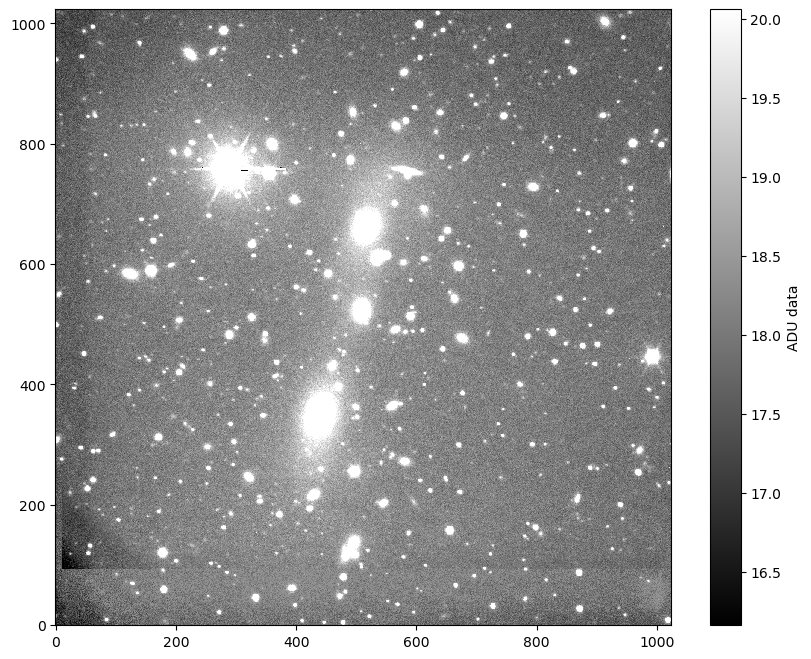

In [131]:
# display the image
sig = 0.2
m, s = np.median(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-sig*s, vmax=m+sig*s, origin='lower')
plt.colorbar(label='ADU data');

plt.show()

In [132]:
#reorder bytes because of fits instead of cfitsio
#data = data.byteswap().newbyteorder()


In [133]:
# convert uint array into float for sep package (otherwise sep.Background breaks)
data = data.astype('f', copy=True)

## 2. Background Subtraction 

In [134]:
# measure a spatially varying background on the image
bkg = sep.Background(data)
bkg = sep.Background(data, bw=128, bh=128, fw=9, fh=9)


In [135]:
# get a "global" mean and noise of the image background (in ADU):
print(bkg.globalback)
print(bkg.globalrms)


18.05538558959961
0.26498469710350037


In [136]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()


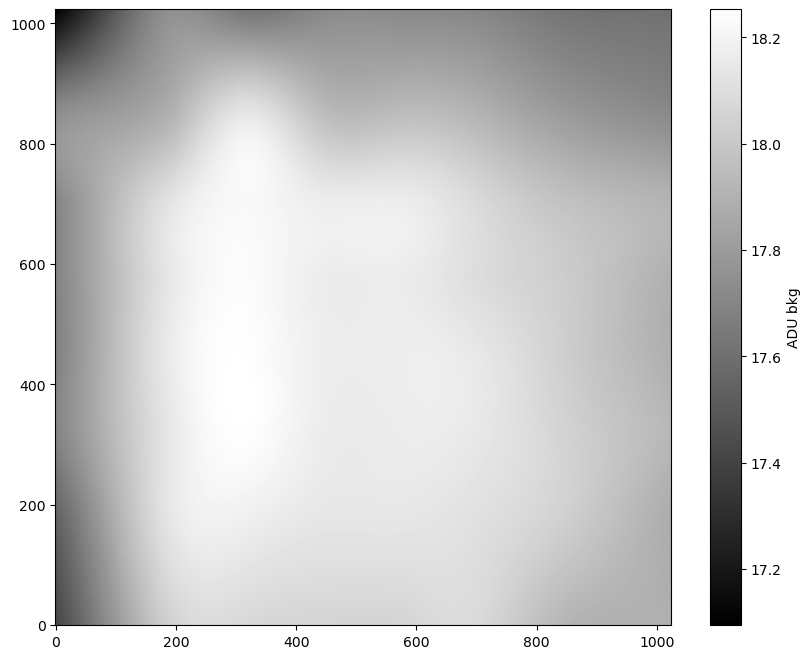

In [137]:
# display the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar(label='ADU bkg');
plt.show()

In [138]:
# subtract the background
data_sub = data - bkg

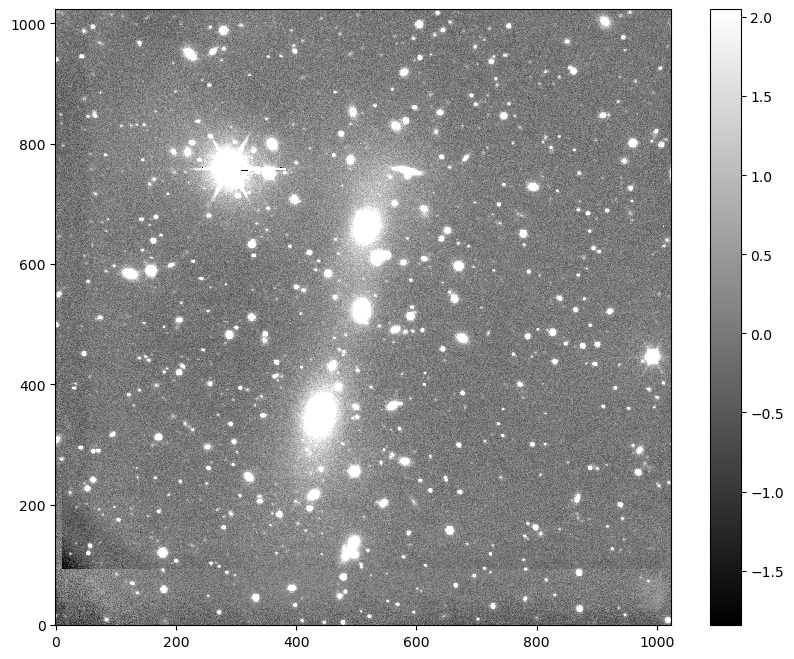

In [139]:
# check subtraction looks good with zero mean
# show the image
m_sub, s_sub = np.median(data_sub), np.std(data_sub)
plt.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m_sub-sig*s_sub, vmax=m_sub+sig*s_sub, origin='lower')
plt.colorbar();

plt.show()

## 3. Source Detection with sep

In [140]:
# Now Object detection
objects = sep.extract(data_sub, 5., err=bkg.globalrms, minarea=10)

In [141]:
# how many objects were detected
len(objects)

359

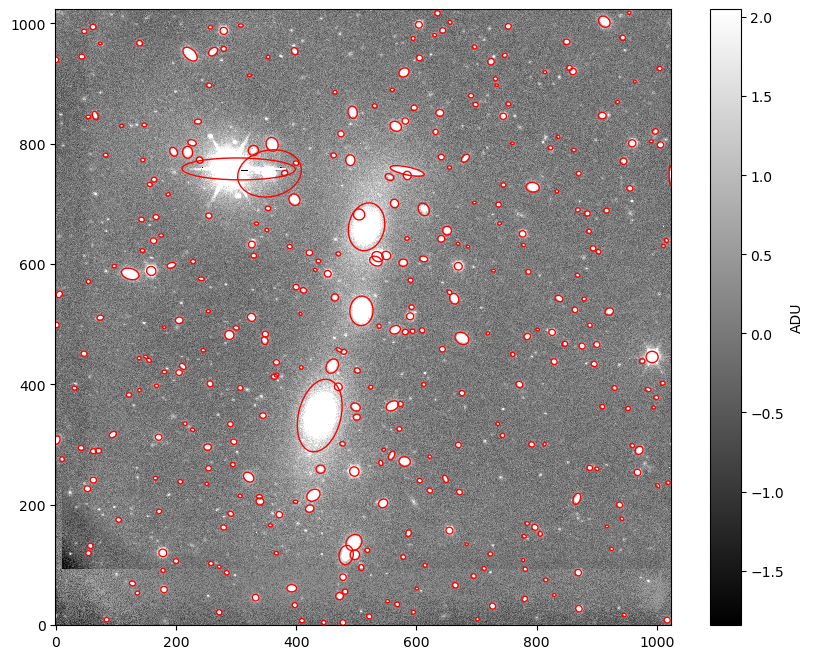

In [142]:
# Show / Display detected objects in red on the bkg subtracted map
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.median(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-sig*s, vmax=m+sig*s, origin='lower')
fig.colorbar(im, ax=ax, label='ADU');

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)



In [143]:
# available fields in objects: lots of informations!
#objects.dtype.names

## 4. Aperture Photometry with sep, also Kron radius, flux_radius

doc here: https://sep.readthedocs.io/en/stable/apertures.html

In [144]:
#Finally, we’ll perform simple circular aperture photometry with a 5 pixel radius at the locations of the objects:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     5.0, err=bkg.globalrms, gain=1.0)


In [145]:
# Equivalent of FLUX_AUTO (e.g., MAG_AUTO) in Source Extractor
# https://sep.readthedocs.io/en/v1.1.x/apertures.html#equivalent-of-flux-auto-e-g-mag-auto-in-source-extractor
kronrad, krflag = sep.kron_radius(data_sub, objects['x'], objects['y'], objects['a'], objects['b'], objects['theta'], 6.0)
flux, fluxerr, flag = sep.sum_ellipse(data_sub, objects['x'], objects['y'], objects['a'], objects['b'], objects['theta'], 2.5*kronrad,
                                      subpix=1, err=bkg.globalrms)

In [146]:
# Equivalent of FLUX_RADIUS in Source Extractor
# flux_radius unit is in pixels
flux_radius, flag = sep.flux_radius(data_sub, objects['x'], objects['y'], 6.*objects['a'], 0.5,
                          normflux=flux, subpix=5)

In [147]:
#flux_radius

In [148]:
#Print all x, y positions, flux measurements, S/N:
for i in range(len(objects)):
    print("object {:d}: x= {:f} y= {:f} flux = {:f} +/- {:f} S/N = {:f}".format(i, objects['x'][i], objects['y'][i], flux[i], fluxerr[i], flux[i]/fluxerr[i]) )

object 0: x= 445.758385 y= 4.188375 flux = 109.871889 +/- 1.947232 S/N = 56.424657
object 1: x= 477.733382 y= 4.100219 flux = 600.369837 +/- 2.248470 S/N = 267.012647
object 2: x= 409.674196 y= 7.138442 flux = 127.149731 +/- 1.892369 S/N = 67.190763
object 3: x= 85.032899 y= 8.673987 flux = 262.466019 +/- 2.018063 S/N = 130.058369
object 4: x= 701.487094 y= 9.539922 flux = 61.793123 +/- 1.242888 S/N = 49.717356
object 5: x= 1016.694913 y= 8.045229 flux = 1397.444191 +/- 2.428625 S/N = 575.405548
object 6: x= 521.443970 y= 14.180363 flux = 216.597651 +/- 1.929118 S/N = 112.278091
object 7: x= 945.474297 y= 16.695027 flux = 65.187000 +/- 1.757710 S/N = 37.086331
object 8: x= 594.916445 y= 21.189160 flux = 66.894943 +/- 2.248470 S/N = 29.751321
object 9: x= 272.118300 y= 21.081970 flux = 379.470709 +/- 2.086492 S/N = 181.870235
object 10: x= 870.065507 y= 27.029594 flux = 2786.551861 +/- 2.569122 S/N = 1084.632013
object 11: x= 397.709442 y= 32.932930 flux = 248.636356 +/- 2.636564 S/N = 

In [149]:
# just checking variable
objects['flux']


array([9.81711731e+01, 5.91559509e+02, 1.15549431e+02, 2.47461365e+02,
       5.60761414e+01, 1.39696704e+03, 2.09052124e+02, 4.90191956e+01,
       4.93173141e+01, 3.72541931e+02, 2.81124243e+03, 2.29635696e+02,
       1.21189001e+03, 1.58947937e+02, 3.72981796e+01, 9.97984161e+01,
       4.23307080e+03, 2.96499443e+01, 2.25831284e+02, 4.12369995e+01,
       2.75806458e+02, 2.38559494e+01, 3.45724219e+03, 1.02133551e+03,
       4.01949097e+02, 1.40834930e+02, 7.23504486e+01, 1.50456390e+02,
       3.83651440e+03, 1.09909714e+02, 2.35578564e+03, 5.30986099e+01,
       8.49943695e+01, 6.65137100e+01, 3.27621307e+01, 4.94818344e+01,
       8.69611282e+01, 9.15198975e+01, 1.77185913e+02, 2.94553261e+01,
       1.07111191e+02, 7.24320221e+01, 4.28404083e+01, 2.17569641e+02,
       8.91355591e+01, 9.97368945e+03, 4.53128738e+01, 2.94335480e+02,
       1.98288841e+01, 1.21551221e+03, 1.21743835e+03, 2.88306714e+03,
       4.12653656e+01, 3.86478958e+01, 1.29025894e+02, 6.24153613e+03,
      

## 5. Now use WCS to get RA, DEC of detected sources

In [150]:
# upload header in the variable w suitable for the rest
w = wcs.WCS(header)


In [151]:
# print w so we make sure all teh WCS information is here
print(w)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 240.595918799 15.9231651623 
CRPIX : 326.470806122 589.298583984 
CD1_1 CD1_2  : -0.000214126860018 -7.86139321139e-07 
CD2_1 CD2_2  : 8.55384910295e-07 -0.000213908363178 
NAXIS : 1024  1024


In [152]:
# reformat x and y in a numpy array
pairs=np.vstack((objects['x'],objects['y'])).T


In [153]:
# convert pairs of x and y into ra, dec in wrd
wrd = w.wcs_pix2world(pairs,0)

In [154]:
# create arrays of ra, dec : prepare input data for cross matching with databases
ra = [radec[0] for radec in wrd]
dec = [radec[1] for radec in wrd]

## 6. Apply zero point (computed elsewhere) to get a fully photometrically calibrated catalog 

In [157]:
if filter == 'R' :
    magr_ohp = -2.5*np.log10(table_in['flux_in']) + zp_r #+ np.log10(exptime)
    table_calibrated=Table([ra,dec,magr_ohp], names =['ra_in','dec_in','magr_ohp'])
    mag2plot = magr_ohp

In [158]:
if filter == 'G' :
    magg_ohp = -2.5*np.log10(table_in['flux_in']) + zp_g #+ np.log10(exptime)
    table_calibrated=Table([ra,dec,magg_ohp], names =['ra_in','dec_in','magg_ohp'])
    mag2plot = magg_ohp

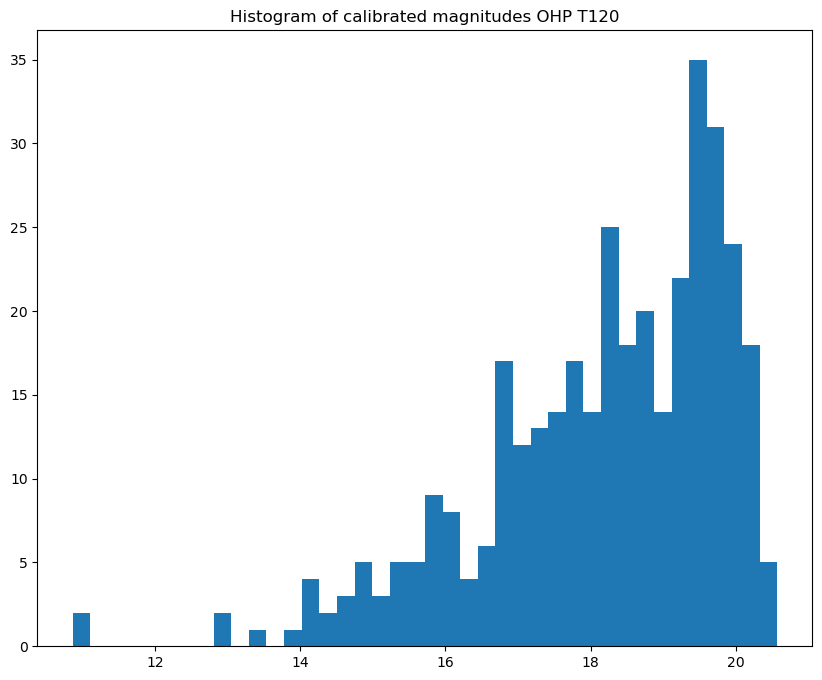

In [159]:
# check also w/ a histogram
n, bins, patches = plt.hist(mag2plot, 40)
plt.title('Histogram of calibrated magnitudes OHP T120')
plt.show()
#table_calibrated

## 6b. Compute errors on magnitudes

In [169]:
# TBD

## 7. Assemble and save calibrated catalog 

In [160]:
# create a table for saving catalog in appropriate format
# ref: https://docs.astropy.org/en/stable/table/index.html#using-table
#table_calibrated=Table([ra,dec,magr_ohp], names =['ra_in','dec_in','magr_ohp'])
#table_calibrated=Table([ra,dec,magr_ohp, emagr_ohp, objects['cxy']], names =['ra_in','dec_in','magr_ohp', 'emagr_ohp', 'cxy'])

if filter == 'R' :
    table_calibrated=Table([ra,dec,magr_ohp, flux_radius], names =['ra_in','dec_in','magr_ohp', 'flux_radius'])

if filter == 'G' :
    table_calibrated=Table([ra,dec,magg_ohp, flux_radius], names =['ra_in','dec_in','magg_ohp', 'flux_radius'])



In [161]:
# check all colums are here and right
#table_calibrated
len(table_in)
#len(table_out)

359

## 8. Save fully calibrated catalog in 1 band on a file 

In [162]:
# write on disk ascii/txt file
# ref: https://docs.astropy.org/en/stable/io/ascii/write.html

if filter == 'R' :
    output_catalog_file = path_data_ohp+'catalog_calibrated_r.dat'
    
if filter == 'G' :
    output_catalog_file = path_data_ohp+'catalog_calibrated_g.dat'

table_calibrated.write(output_catalog_file, format='ascii', overwrite=True) 


## 9. Cross-match ra, dec of detected sources with databases in CDS / Vizier for checks

In [155]:
table_in=Table([ra,dec,flux], names =['ra_in','dec_in','flux_in'])


In [156]:
table_out = XMatch.query(cat1=table_in, cat2='vizier:II/349/ps1',max_distance=0.3 * u.arcsec, 
                     colRA1='ra_in',colDec1='dec_in')
#table_out

## 10. Check calibrated catalog against databases

In [163]:
if filter == 'R' :
    mag_databases = table_out['rmag']
    mag_ohp2plot = -2.5*np.log10(table_out['flux_in']) + zp_r #+ np.log10(exptime)

if filter == 'G' :
    mag_databases = table_out['gmag']
    mag_ohp2plot = -2.5*np.log10(table_out['flux_in']) + zp_g #+ np.log10(exptime)


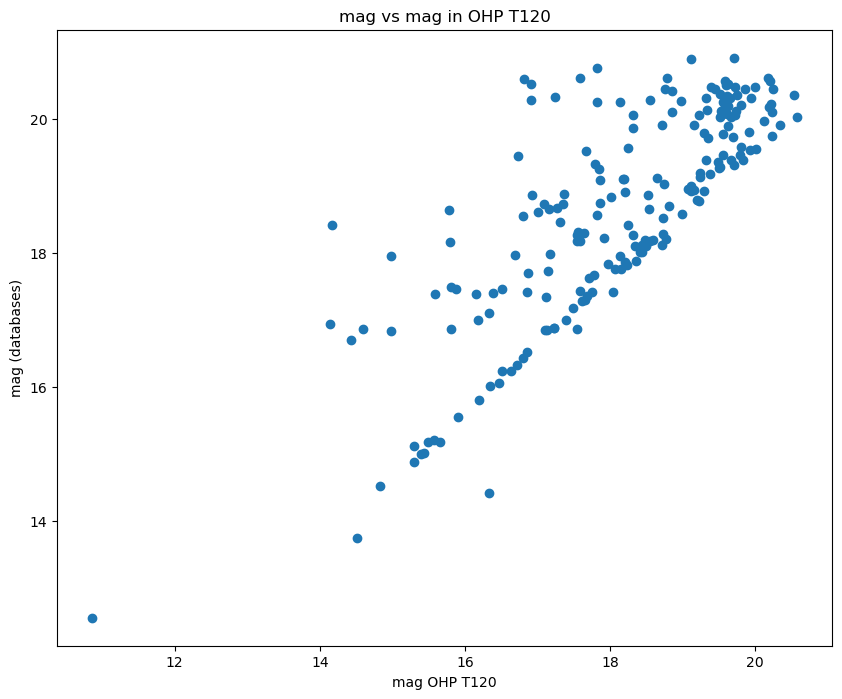

In [164]:
# show x= mag instrumentale; y= rmag from databases
plt.scatter(mag_ohp2plot,mag_databases)
plt.title("mag vs mag in OHP T120")
plt.xlabel("mag OHP T120")
plt.ylabel("mag (databases)")
plt.show()